## In this notebook, we will
1. Tune the batch size for our NN model

From  <font color='blue'>1.MolRedPot_NN_LearningRateTuning.ipynb</font>, the tuned value of the learning rate is 1e-3.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from decimal import Decimal
import time as time

from tensorflow.keras.models import Sequential, model_from_json
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#Sklearn tools
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Keras specials
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.backend import clear_session

## Import training data and split into training+validation sets

In [43]:
features=pd.read_csv('../Data/features_train.csv',index_col=0)
target=pd.read_csv('../Data/target_train.csv',index_col=0)['ERed']

features_std = StandardScaler().fit_transform(features)

In [44]:
features_train,features_val,target_train,target_val=train_test_split(features_std,target,test_size=0.2,random_state=15)

In [45]:
features_train=tf.convert_to_tensor(features_train,dtype=tf.float64)
target_train=tf.convert_to_tensor(target_train,dtype=tf.float64)
features_val=tf.convert_to_tensor(features_val,dtype=tf.float64)
target_val=tf.convert_to_tensor(target_val,dtype=tf.float64)

## Define dictionary; which will store the NN performance metrics for varying learning rates

In [46]:
bs_grid={}

In [47]:
def nn_arch():
    
    num_dens_layers=4     
    n_nodes=[64, 32,16, 1]
    learning_rate=1e-3

    model = Sequential()
    model.add(Dense(n_nodes[0], kernel_initializer='normal',input_dim = features.shape[1], activation='relu')) # first hidden layer
    
    for i in range(1,num_dens_layers):
        model.add(Dense(n_nodes[i], kernel_initializer='normal',activation='relu'))    
    
    model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=1e-3), metrics=['mean_absolute_error'])
    
    return model

In [55]:
def bs_tuning(bs):
    
    t1=time.time()
    
    model=nn_arch()
    
    history=model.fit(features_train, target_train, 
                      epochs=50, batch_size=bs, 
                      validation_data = (features_val, target_val), verbose=0)
    t2=time.time()
    
    training_loss=(history.history['mean_absolute_error'])
    validation_loss=(history.history['val_mean_absolute_error'])
    
    train_nn=model.predict(features_train)
    val_nn=model.predict(features_val)
    training_r2=r2_score(target_train,train_nn)
    validation_r2=r2_score(target_val,val_nn)
    
    temp={}
    temp['Training_loss']=training_loss
    temp['Validation_loss']=validation_loss
    temp['Training_r2']=training_r2
    temp['Validation_r2']=validation_r2
    temp['Training_time']=t2-t1
    
    bs_grid[str(bs)]=temp
    
    print('batch size = ',bs,'training time = ',t2-t1)
    
    clear_session()

In [56]:
batch_sizes=[16,32,64,128,256]
for bs in batch_sizes:
    bs_tuning(bs)

28/28 [==============================] - 0s 1ms/step
batch size =  16 training time =  20.346914529800415
28/28 [==============================] - 0s 1ms/step
batch size =  32 training time =  11.03730821609497
28/28 [==============================] - 0s 1ms/step
batch size =  64 training time =  6.359159469604492
28/28 [==============================] - 0s 1ms/step
batch size =  128 training time =  4.450071573257446
28/28 [==============================] - 0s 1ms/step
batch size =  256 training time =  3.2107937335968018


## Plotting 'training loss vs epochs' for different batch sizes

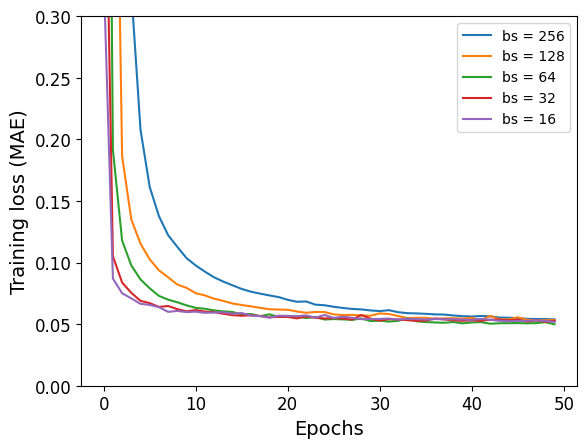

In [57]:
for k in list(bs_grid.keys())[::-1]:
    plt.plot(bs_grid[k]['Training_loss'],label='bs = '+str(k))
    plt.ylim([0,0.3])
plt.xlabel('Epochs',fontsize=14)    
plt.xticks(fontsize=12)
plt.ylabel('Training loss (MAE)',fontsize=14)    
plt.yticks(fontsize=12)
plt.legend()
plt.show()

## Comparing training times

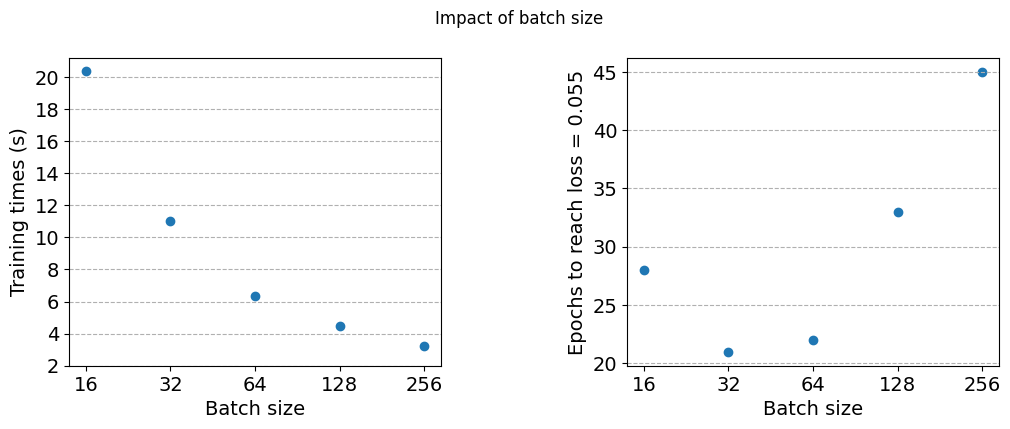

In [140]:
fig, ax = plt.subplots(1, 2,figsize=(12,4))
plt.subplots_adjust(wspace=0.5)

fig.suptitle('Impact of batch size',y=1)

ax[0].scatter(range(len(batch_sizes)),[bs_grid[k]['Training_time'] for k in bs_grid.keys()])
ax[0].set_xticks(range(len(batch_sizes)),batch_sizes,fontsize=14)
ax[0].set_xlabel('Batch size',fontsize=14)
ax[0].set_ylabel('Training times (s)',fontsize=14)
ax[0].set_yticks(range(2,22,2),range(2,22,2),fontsize=14)
ax[0].grid(axis='y',ls='--')

ax[1].scatter(range(len(batch_sizes)),[np.where(np.array(bs_grid[str(k)]['Training_loss'])<0.055)[0][0] for k in batch_sizes])
ax[1].set_ylabel('Epochs to reach loss = 0.055',fontsize=14)
ax[1].set_xlabel('Batch size',fontsize=14)
ax[1].set_xticks(range(len(batch_sizes)),batch_sizes,fontsize=14)
ax[1].set_yticks(range(20,50,5),range(20,50,5),fontsize=14)
ax[1].grid(axis='y',ls='--')

plt.show()

Larger batch sized result in faster training times, for the same number of epochs.

However, larger number of epochs are required to reach the same training MAE loss.

## <font color='blue'>The tuned value of the batch size is 64</font>